In [1]:
import argparse
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from PIL import Image

import os
import sys
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as patches

#==========================================================================
# JUPYTER PATH STUFF. Not present in the main script coz does not affect it
# =========================================================================

os.chdir("..")


root = Path().resolve()
while root != root.parent:
    if (root / "scripts").is_dir():
        sys.path.insert(0, str(root))
        print("Added to sys.path:", root)
        break
    root = root.parent
else:
    raise RuntimeError("Could not find 'scripts' directory above this notebook")

from scripts.src import (
    build_model_and_tokenizer,
    get_image_transform,
    get_label_text_embeddings,
)

Added to sys.path: /home/woody/iwi5/iwi5362h/ALBEF


In [2]:
def infer_png_path(images_root: Path, image_id: str) -> Path:
    png_path = images_root / f"{image_id}.png"
    if not png_path.exists():
        raise FileNotFoundError(f"No PNG found for image_id={image_id} at {png_path}")
    return png_path


def gradcam_for_single_label(
    model,
    img_tensor: torch.Tensor,    # (1,3,H,W)
    text_feat: torch.Tensor,     # (D,), normalized
    device: torch.device,
    patch_grid: int,
) -> torch.Tensor:
    """
    Compute Grad-CAM over ViT patch tokens for a single label.

    Steps:
      1. Forward: image -> visual_encoder -> vision_proj -> tokens
      2. Define scalar score = cosine(image_CLS, text_feat)
      3. Backward: d(score)/d(patch_tokens)
      4. Grad-CAM: weights = mean over spatial gradients
         heatmap[h,w] = ReLU( Σ_k weights[k] * patch_feats[h,w,k] )
    """
    model.zero_grad()

    img_tensor = img_tensor.to(device, non_blocking=True)
    img_tensor.requires_grad_(True)

    image_embeds = model.visual_encoder(img_tensor)   # (1, N+1, 768)
    image_embeds = model.vision_proj(image_embeds)    # (1, N+1, D)

    # CLS and patches
    image_cls = image_embeds[:, 0, :]                 # (1, D)
    patch_tokens = image_embeds[:, 1:, :]             # (1, N, D)

    # normalize CLS for cosine similarity
    image_cls_norm = F.normalize(image_cls, dim=-1)   # (1, D)
    text_feat = text_feat.to(device)
    text_feat = text_feat.view(1, -1)                 # (1, D)

    # ---- Scalar score for this label ----
    # score = cosine(image_cls, text_feat)
    score = (image_cls_norm * text_feat).sum(dim=-1)  # (1,)
    score = score.squeeze(0)                          # scalar

    # ---- Backward: gradients w.r.t patch tokens ----
    patch_tokens.retain_grad()
    score.backward(retain_graph=False)

    grads = patch_tokens.grad      # (1, N, D)
    feats = patch_tokens           # (1, N, D)

    # ---- Grad-CAM: weights over channels ----
    # average gradient over spatial dimension N
    weights = grads.mean(dim=1)    # (1, D)
    weights = weights.squeeze(0)   # (D,)

    # apply weights to patch features
    feats = feats.squeeze(0)       # (N, D)
    cam = (feats * weights).sum(dim=-1)  # (N,)

    # reshape to (H', W')
    N = cam.shape[0]
    grid_auto = int(np.sqrt(N))
    if grid_auto * grid_auto != N:
        raise ValueError(f"Cannot reshape N={N} into square grid.")
    if patch_grid is None:
        patch_grid = grid_auto

    if patch_grid * patch_grid != N:
        raise ValueError(
            f"patch_grid={patch_grid} but N={N} (should be {patch_grid*patch_grid})."
        )

    cam = cam.view(patch_grid, patch_grid)  # (H', W')

    # ReLU and normalize
    cam = F.relu(cam)
    if cam.max() > 0:
        cam = cam / (cam.max() + 1e-6)

    return cam   # (H', W') on device


def upsample_cam(cam: torch.Tensor, target_size: int) -> torch.Tensor:
    """
    cam: (H', W') on device
    returns: (target_size, target_size) on CPU
    """
    cam_4d = cam.unsqueeze(0).unsqueeze(0)   # (1,1,H',W')
    cam_up = F.interpolate(
        cam_4d,
        size=(target_size, target_size),
        mode="bilinear",
        align_corners=False,
    )
    cam_up = cam_up.squeeze(0).squeeze(0)    # (H, W)
    return cam_up.cpu()

In [3]:
images_root = Path("/home/woody/iwi5/iwi5362h/data/vindr_cxr/test")
output_dir = Path("/home/woody/iwi5/iwi5362h/ALBEF/results/zero_shot_vindr_results/heatmaps_grad")
output_dir.mkdir(parents=True, exist_ok=True)

In [4]:
config_path = "configs/Pretrain.yaml"
ckpt_path = "output_mimic_a40_transformations/checkpoint_29.pth"
device = "cuda"

In [5]:
torch.cuda.get_device_name(0)

'NVIDIA A40'

In [6]:
# Load model/tokenizer/config once and reuse
model, tokenizer, config, device = build_model_and_tokenizer(
    config_path=config_path,
    ckpt_path=ckpt_path,
    device=device,
)

image_res = config["image_res"]

[Model] Building ALBEF...
[Model] State dict loaded: <All keys matched successfully>


In [7]:
transform = get_image_transform(image_res)
# Load label CSV to get image_ids + label names
df = pd.read_csv("/home/woody/iwi5/iwi5362h/data/vindr_cxr/annotations/image_labels_test.csv")
id_col = df.columns[0]
label_cols = list(df.columns[1:])
print(f"[Data] Found {len(df)} rows, {len(label_cols)} labels")

[Data] Found 3000 rows, 28 labels


In [8]:
# For debugging a small batch
df = df.iloc[: 100].reset_index(drop=True)
print(f"[Data] Limiting to {len(df)} images (max_images=100)")

[Data] Limiting to 100 images (max_images=100)


In [9]:
df["__has_png__"] = df[id_col].apply(
    lambda x: (images_root / f"{x}.png").exists()
)
df = df[df["__has_png__"]].reset_index(drop=True)
print(f"[Data] After PNG filter: {len(df)} images")

image_ids = df[id_col].tolist()
label_names = label_cols

[Data] After PNG filter: 100 images


In [10]:
# Multi-prompt text embeddings
all_label_embs = get_label_text_embeddings(
    model=model,
    tokenizer=tokenizer,
    labels=label_names,
    device=device,
    max_length=32,
)  # (L, D)
all_label_embs = all_label_embs.to(device)
print("[Text] Label embeddings shape:", all_label_embs.shape)

[Text] Total prompts: 136 for 28 labels
[Text] Label embeddings shape: torch.Size([28, 256])


In [11]:
# Map label -> embedding index
label_to_idx = {lb: i for i, lb in enumerate(label_cols)}

In [12]:
# Prepare subset embedding tensor
subset_indices = [label_to_idx[lb] for lb in label_names]
subset_embs = all_label_embs[subset_indices]  # (L_sub, D)

In [13]:
def gradcam_for_single_label(
    model,
    img_tensor: torch.Tensor,    # (1,3,H,W)
    text_feat: torch.Tensor,     # (D,), normalized
    device: torch.device,
    patch_grid: int,
) -> torch.Tensor:
    """
    Gradient-based refinement of the similarity heatmap.

    Steps:
      1. Forward: image -> visual_encoder -> vision_proj -> patch_tokens (no CLS).
      2. Compute patch–text similarity map sim[h,w].
      3. Define scalar score = mean(sim) so it depends on ALL patches.
      4. Backward: d(score)/d(patch_tokens).
      5. Grad-CAM: weights = mean over spatial gradients,
         cam[h,w] = ReLU( sum_k weights[k] * patch_feats[h,w,k] ).
    """
    model.zero_grad()

    img_tensor = img_tensor.to(device, non_blocking=True)

    # ----- Forward pass with grad -----
    img_tensor.requires_grad_(False)  # we don't need grad wrt image
    image_embeds = model.visual_encoder(img_tensor)   # (1, N+1, 768)
    image_embeds = model.vision_proj(image_embeds)    # (1, N+1, D)

    # Only patch tokens
    patch_tokens = image_embeds[:, 1:, :]             # (1, N, D)
    patch_tokens = F.normalize(patch_tokens, dim=-1)  # cos space

    # Make sure autograd tracks patch_tokens
    patch_tokens.requires_grad_(True)

    # ----- Patch–text similarity -----
    text_feat = text_feat.to(device)
    text_feat = text_feat.view(1, 1, -1)              # (1,1,D)

    # sim: (1, N) = cosine similarity per patch
    sim = (patch_tokens * text_feat).sum(dim=-1)      # (1, N)

    # define scalar score as the mean similarity over all patches
    score = sim.mean()                                # scalar

    # ----- Backward: gradients wrt patch_tokens -----
    patch_tokens.retain_grad()
    score.backward()

    grads = patch_tokens.grad        # (1, N, D)
    feats = patch_tokens             # (1, N, D)

    # ----- Grad-CAM weighting -----
    # average gradient over spatial dimension N
    weights = grads.mean(dim=1)      # (1, D)
    weights = weights.squeeze(0)     # (D,)

    feats = feats.squeeze(0)         # (N, D)
    cam = (feats * weights).sum(dim=-1)  # (N,)

    # reshape to (H', W')
    N = cam.shape[0]
    grid_auto = int(np.sqrt(N))
    if grid_auto * grid_auto != N:
        raise ValueError(f"Cannot reshape N={N} into square grid.")
    if patch_grid is None:
        patch_grid = grid_auto
    if patch_grid * patch_grid != N:
        raise ValueError(
            f"patch_grid={patch_grid} but N={N} "
            f"(should be {patch_grid*patch_grid})."
        )

    cam = cam.view(patch_grid, patch_grid)  # (H', W')

    # ReLU + normalize to [0,1]
    cam = F.relu(cam)
    if cam.max() > 0:
        cam = cam / (cam.max() + 1e-6)

    return cam   # (H', W')

In [14]:
# ---- Process images ----
gradcam_index_records = []
patch_grid = 16  # ViT patch grid

for idx, image_id in tqdm(enumerate(image_ids, start=1)):
    try:
        img_path = infer_png_path(images_root, image_id)
    except FileNotFoundError as e:
        print("[WARN]", e)
        continue

    img_pil = Image.open(img_path).convert("RGB")
    img_tensor = transform(img_pil).unsqueeze(0)  # (1,3,H,W)

    heatmaps = {}
    for j, label in enumerate(label_names):
        text_feat = subset_embs[j]  # (D,)
        cam = gradcam_for_single_label(
            model=model,
            img_tensor=img_tensor,
            text_feat=text_feat,
            device=device,
            patch_grid=patch_grid,
        )
        cam_up = upsample_cam(cam, target_size=image_res)  # (H,W)

        heatmaps[label] = cam_up  # keep as tensor for saving

    out_path = output_dir / f"{image_id}.pt"
    # convert to tensors (already are), but ensure CPU/float
    heatmaps_cpu = {k: v.float().cpu() for k, v in heatmaps.items()}
    torch.save(heatmaps_cpu, out_path)
    gradcam_index_records.append(
        {"image_id": image_id, "heatmap_path": str(out_path)}
    )

    if idx % 20 == 0 or idx == len(image_ids):
        print(f"[Grad-CAM] Processed {idx}/{len(image_ids)} images")

20it [00:11,  1.71it/s]

[Grad-CAM] Processed 20/100 images


40it [00:23,  1.71it/s]

[Grad-CAM] Processed 40/100 images


60it [00:35,  1.70it/s]

[Grad-CAM] Processed 60/100 images


80it [00:46,  1.71it/s]

[Grad-CAM] Processed 80/100 images


100it [00:58,  1.70it/s]

[Grad-CAM] Processed 100/100 images


In [17]:
index_df = pd.DataFrame(gradcam_index_records)
index_df.head()

,image_id,heatmap_path
0,e0dc2e79105ad93532484e956ef8a71a,/home/woody/iwi5/iwi5362h/ALBEF/results/zero_s...
1,0aed23e64ebdea798486056b4f174424,/home/woody/iwi5/iwi5362h/ALBEF/results/zero_s...
2,aa15cfcfca7605465ca0513902738b95,/home/woody/iwi5/iwi5362h/ALBEF/results/zero_s...
3,665c4a6d2693dc0286d65ab479c9b169,/home/woody/iwi5/iwi5362h/ALBEF/results/zero_s...
4,42da2c134b53cb5594774d3d29faac59,/home/woody/iwi5/iwi5362h/ALBEF/results/zero_s...


In [16]:
img_path

PosixPath('/home/woody/iwi5/iwi5362h/data/vindr_cxr/test/ca40cec6911dc19ae5a22ef7b474eea9.png')

In [33]:
# Visualization

def load_meta(meta_csv):
    """
    Load VinDr meta CSV with columns: image_id, dim0, dim1
    Returns dict: image_id -> (orig_height, orig_width)
    """
    df = pd.read_csv(meta_csv)
    return {r["image_id"]: (int(r["dim0"]), int(r["dim1"])) for _, r in df.iterrows()}


def visualize_heatmaps_and_gt_per_label(
    image_id: str,
    images_root: str,
    annotations_csv: str,
    meta_csv: str,
    heatmaps_root: str,
    save_dir: str = None,   # << OPTIONAL
    alpha: float = 0.45,
    cmap: str = "jet",
    only_labels=None,
):
    """
    For a given VinDr image:
      - Plot heatmap + GT bounding box *per label instance* (one figure each).
      - Always SHOW the images.
      - SAVE ONLY if save_dir is provided.

    Produces:
      - If image has 5 GT boxes → shows 5 separate images.
      - If save_dir=None → only displays, does NOT save.
    """
    images_root = Path(images_root)
    heatmaps_root = Path(heatmaps_root)
    save_dir = Path(save_dir) if save_dir else None
    if save_dir is not None:
        save_dir.mkdir(parents=True, exist_ok=True)

    # ------------------ Load Annotations ------------------
    df_ann = pd.read_csv(annotations_csv)
    rows = df_ann[df_ann["image_id"] == image_id]
    if rows.empty:
        raise ValueError(f"No annotations found for image_id={image_id}")

    if only_labels is not None:
        rows = rows[rows["class_name"].isin(only_labels)]
        if rows.empty:
            raise ValueError(f"No GT annotations for the requested labels: {only_labels}")

    # ------------------ Load Original Meta ------------------
    meta = load_meta(meta_csv)
    if image_id not in meta:
        raise KeyError(f"{image_id} not found in meta CSV {meta_csv}")
    orig_h, orig_w = meta[image_id]

    # ------------------ Load Image ------------------
    img_path = images_root / f"{image_id}.png"
    if not img_path.exists():
        raise FileNotFoundError(f"Missing PNG: {img_path}")
    img = Image.open(img_path).convert("RGB")
    w_png, h_png = img.size
    if w_png != 256 or h_png != 256:
        raise AssertionError(f"Expected 256x256 image, got {w_png}x{h_png}")

    scale_x = w_png / float(orig_w)
    scale_y = h_png / float(orig_h)

    # ------------------ Load Heatmaps ------------------
    hm_path = heatmaps_root / f"{image_id}.pt"
    if not hm_path.exists():
        raise FileNotFoundError(f"[Error] Missing heatmap file: {hm_path}")

    heatmaps = torch.load(hm_path, map_location="cpu")
    heatmaps_np = {}
    for label, hm_tensor in heatmaps.items():
        hm = hm_tensor.float()
        # normalize 0–1
        if hm.max() > hm.min():
            hm = (hm - hm.min()) / (hm.max() - hm.min())
        else:
            hm = torch.zeros_like(hm)
        heatmaps_np[label] = hm.detach().cpu().numpy()

    # ------------------ Iterate Over GT Boxes ------------------
    for idx, r in rows.iterrows():
        label = r["class_name"]

        if label not in heatmaps_np:
            print(f"[WARN] No heatmap for label '{label}' → skipping.")
            continue

        heatmap = heatmaps_np[label]

        # Resize heatmap if needed
        H_img, W_img = img.size[1], img.size[0]
        if heatmap.shape != (H_img, W_img):
            heatmap = np.array(
                Image.fromarray((heatmap * 255).astype(np.uint8)).resize(
                    (W_img, H_img), resample=Image.BILINEAR
                )
            ) / 255.0

        # ------------------ Scale GT Box ------------------
        x_min = r["x_min"] * scale_x
        y_min = r["y_min"] * scale_y
        x_max = r["x_max"] * scale_x
        y_max = r["y_max"] * scale_y

        width = x_max - x_min
        height = y_max - y_min

        # ------------------ Create Visualization ------------------
        fig, ax = plt.subplots(figsize=(6, 6))

        ax.imshow(img)
        ax.imshow(heatmap, cmap=cmap, alpha=alpha)

        rect = patches.Rectangle(
            (x_min, y_min),
            width,
            height,
            linewidth=2,
            edgecolor="lime",
            facecolor="none",
        )
        ax.add_patch(rect)

        ax.text(
            x_min,
            max(y_min - 5, 0),
            label,
            fontsize=9,
            color="black",
            bbox=dict(facecolor="yellow", alpha=0.6, edgecolor="none"),
        )

        ax.axis("off")
        ax.set_title(f"{image_id} — {label}")

        # SHOW ALWAYS
        plt.show()

        # SAVE OPTIONAL
        if save_dir is not None:
            out_name = f"{image_id}_{label.replace(' ', '_')}_{idx}.png"
            out_path = save_dir / out_name
            fig.savefig(out_path, bbox_inches="tight", pad_inches=0, dpi=150)
            print(f"[Saved] {out_path}")

        plt.close(fig)

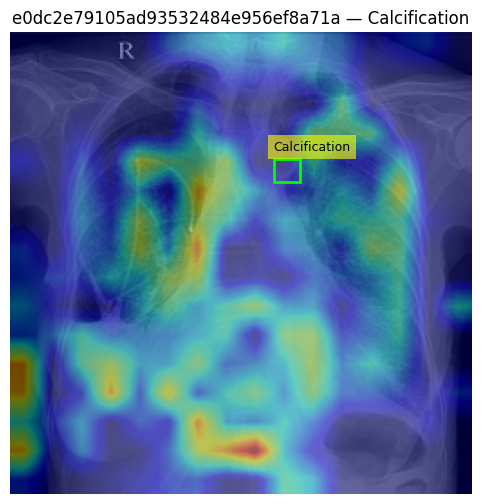

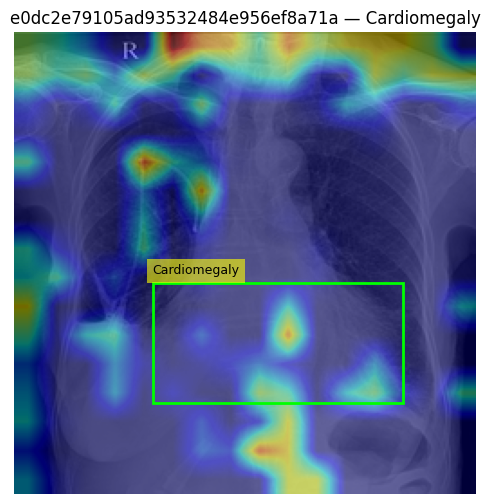

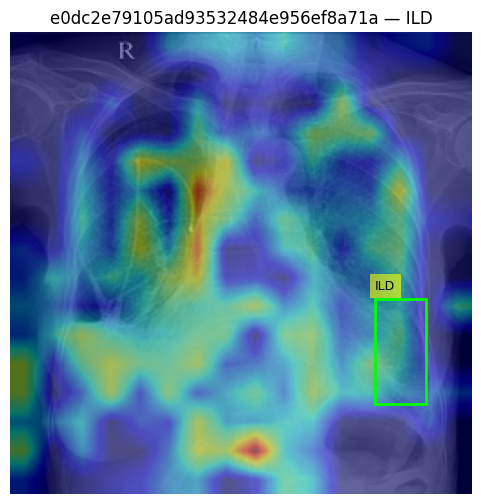

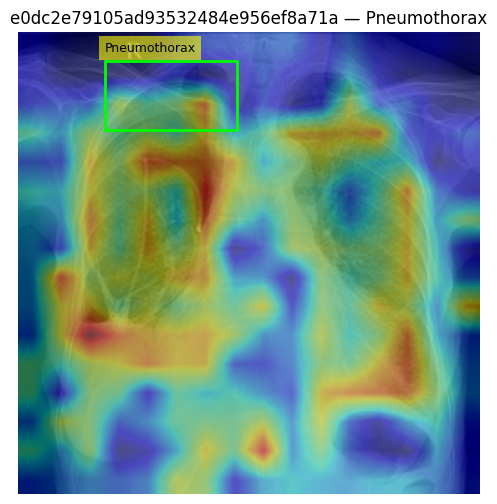

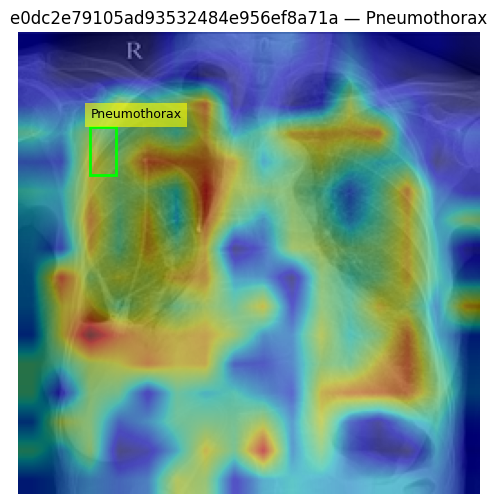

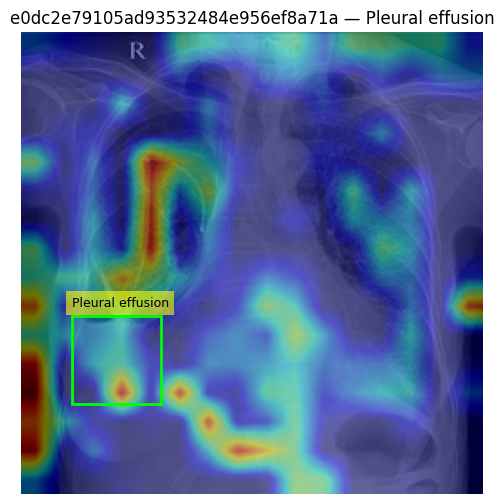

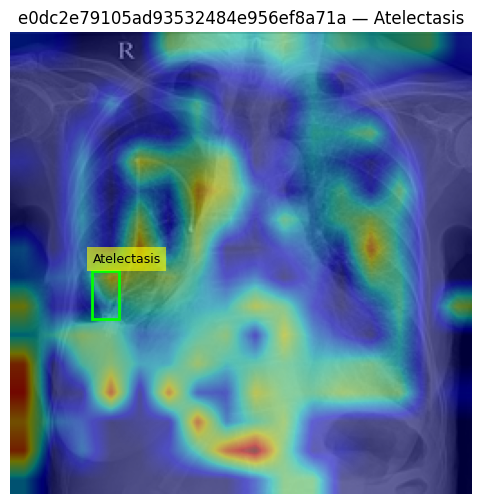

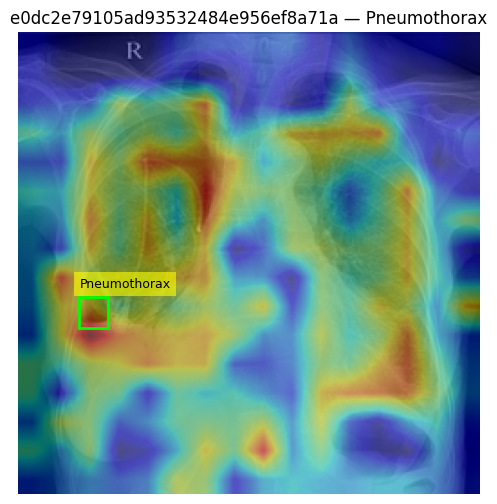

In [34]:
visualize_heatmaps_and_gt_per_label(
    image_id="e0dc2e79105ad93532484e956ef8a71a",
    images_root="/home/woody/iwi5/iwi5362h/data/vindr_cxr/test/",
    annotations_csv="/home/woody/iwi5/iwi5362h/data/vindr_cxr/annotations/annotations_test.csv",
    meta_csv="/home/woody/iwi5/iwi5362h/data/vindr_cxr/test_meta.csv",
    heatmaps_root="/home/woody/iwi5/iwi5362h/ALBEF/results/zero_shot_vindr_results/heatmaps_grad",
)